# Gapped k-mer Support Vector Machine (gkSVM) Classification
Adam Klie 
08/02/2021

Notebook to preprocess the data for, train and evaluate a gkSVM classsifier based on the implmentation in https://github.com/Dongwon-Lee/lsgkm/.

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Loading webpages
from IPython.display import IFrame

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [95]:
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils

# Define parameters of the notebook

In [140]:
DATASET = "2021-OLS-Library"  # Which dataset to look at
FEATURES = "fasta"  # What features to use to train the model
LABELS = "binary"
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"
TRAIN = True
SPLIT = 0.9
SUBSET = False
HYPERPARAM = "baseline-positive-weighted"

# Check gkSVM assumptions

# Train and test gkSVM model with script

## gkSVM Training and testing

In [141]:
#sbatch gkSVM.sh OLS.tr.fa OLS.neg.tr.fa OLS.test.fa OLS.neg.test.fa OLS

In [142]:
#!gkmpredict OLS.tr.fa OLS.model.txt OLS.tr.predict.txt
#!gkmpredict OLS.neg.tr.fa OLS.model.txt OLS.neg.tr.predict.txt

## gkSVM evaluation with help from downloaded script 
https://raw.githubusercontent.com/kundajelab/lsgkm/master/scripts/lsgkm_eval.py 

**Provided script**

In [144]:
out_dir = "Result_{0}_{1}_gkSVM-clf_{2}".format(PREPROCESS, FEATURES, HYPERPARAM)
pos_tr_file = os.path.join(out_dir, "{0}_{1}_gkSVM-clf_{2}.tr.predict.txt".format(PREPROCESS, FEATURES, HYPERPARAM))
neg_tr_file = os.path.join(out_dir, "{0}_{1}_gkSVM-clf_{2}.neg.tr.predict.txt".format(PREPROCESS, FEATURES, HYPERPARAM))
pos_file = os.path.join(out_dir, "{0}_{1}_gkSVM-clf_{2}.predict.txt".format(PREPROCESS, FEATURES, HYPERPARAM))
neg_file = os.path.join(out_dir, "{0}_{1}_gkSVM-clf_{2}.neg.predict.txt".format(PREPROCESS, FEATURES, HYPERPARAM))

In [145]:
print(pos_tr_file)

Result_0.18-0.4_fasta_gkSVM-clf_baseline-positive-weighted/0.18-0.4_fasta_gkSVM-clf_baseline-positive-weighted.tr.predict.txt


In [146]:
# Train
project_utils.score(pos_tr_file, neg_tr_file, 0)

Metric	Value	Randomised
Accuracy_at_threshold_0	0.7663	0.5953
AUROC	0.7760	0.4985
AUPRC	0.6556	0.3105


In [147]:
# Test
project_utils.score(pos_file, neg_file, 0)

Metric	Value	Randomised
Accuracy_at_threshold_0	0.7643	0.5965
AUROC	0.7748	0.4992
AUPRC	0.6517	0.3080


**Training scores**

In [148]:
# Make sure ordering is correct
pos_tr_scores = project_utils.get_scores(pos_tr_file)
neg_tr_scores = project_utils.get_scores(neg_tr_file)

In [149]:
y_tr_probs = np.array(pos_tr_scores + neg_tr_scores)
y_tr_preds = (y_tr_probs >= 0).astype(int)
y_train = np.array([1]*len(pos_tr_scores) + [0]*len(neg_tr_scores))
print(y_train.shape, y_tr_probs.shape, y_tr_preds.shape)

(272642,) (272642,) (272642,)


**Test scores**

In [150]:
# Make sure ordering is correct
pos_scores = project_utils.get_scores(pos_file)
neg_scores = project_utils.get_scores(neg_file)

In [151]:
y_probs = np.array(pos_scores + neg_scores)
y_preds = (y_probs >= 0).astype(int)
y_test = np.array([1]*len(pos_scores) + [0]*len(neg_scores))
print(y_test.shape, y_probs.shape, y_preds.shape)

(30294,) (30294,) (30294,)


In [115]:
project_utils.classification_report(filename="{}_{}_{}_gkSVM-Classificaton-Report.md".format(PREPROCESS, FEATURES, HYPERPARAM),
                                    md_title="{}_{}_{}_gkSVM-Classificaton-Report".format(PREPROCESS, FEATURES, HYPERPARAM),
                                    clf=clf, train_X=X_train, test_X=X_test, train_y=y_train, test_y=y_test)

NameError: name 'clf' is not defined

### <u>**Confusion matrices** </u>

In [152]:
from sklearn.metrics import confusion_matrix

In [117]:
np.unique(y_tr_preds, return_counts=True), np.unique(y_preds, return_counts=True)

((array([0, 1]), array([205212,  67379])),
 (array([0, 1]), array([22772,  7516])))

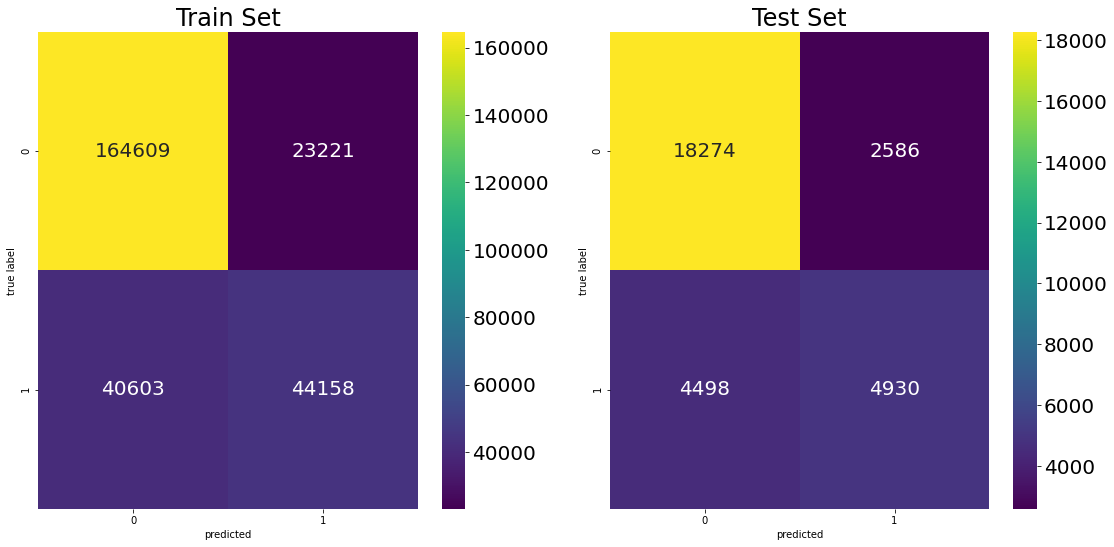

In [118]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

rc = {"font.size": 20}
with plt.rc_context(rc):
    sns.heatmap(confusion_matrix(y_train, y_tr_preds), annot=True, fmt='d', cmap='viridis', ax=ax[0])
    ax[0].set_xlabel('predicted')
    ax[0].set_ylabel('true label')
    ax[0].set_title('Train Set')

    sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='d', cmap='viridis', ax=ax[1])
    ax[1].set_xlabel('predicted')
    ax[1].set_ylabel('true label')
    ax[1].set_title('Test Set')
    
    plt.tight_layout();

### <u> **Accuracies** </u>

In [119]:
from sklearn.metrics import accuracy_score

In [120]:
train_acc, test_acc = accuracy_score(y_true=y_train, y_pred=y_tr_preds), accuracy_score(y_true=y_test, y_pred=y_preds)

In [121]:
print("Train Acc", "Test Acc", sep='\t')
print("{:.4f}\t{:.4f}".format(train_acc, test_acc))

Train Acc	Test Acc
0.7659	0.7661


### <u> **F-scores** </u>

In [122]:
IFrame('https://en.wikipedia.org/wiki/F-score', width=800, height=400)

In [123]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [124]:
def fbeta_score(pr, rec, beta):
    return (1+(beta**2))*((pr*rec)/(((beta**2)*pr)+rec))

In [125]:
train_prec, test_prec = precision_score(y_true=y_train, y_pred=y_tr_preds), precision_score(y_true=y_test, y_pred=y_preds)

In [126]:
train_recall, test_recall = recall_score(y_true=y_train, y_pred=y_tr_preds), recall_score(y_true=y_test, y_pred=y_preds)

In [127]:
train_f1, test_f1 = f1_score(y_true=y_train, y_pred=y_tr_preds), f1_score(y_true=y_test, y_pred=y_preds)

In [128]:
fbeta_tr_scores = []
fbeta_scores = []
for b in [0.1, 0.5, 1, 2, 10]:
    fbeta_tr_scores.append(fbeta_score(train_prec, train_recall, b))
    fbeta_scores.append(fbeta_score(test_prec, test_recall, b))

In [129]:
print("Metric", "Train", "Test", sep='\t')
print("{:s}\t{:.4f}\t{:.4f}".format("Precision", train_prec, test_prec))
print("{:s}\t{:.4f}\t{:.4f}".format("Recall", train_recall, test_recall))
#print("{:s}\t{:.4f}\t{:.4f}".format("F1-Score", train_f1, test_f1))
for i, b in enumerate([0.1, 0.5, 1, 2, 10]):
    print("F{:s}-Score\t{:.4f}\t{:.4f}".format(str(b), fbeta_tr_scores[i], fbeta_scores[i])) 

Metric	Train	Test
Precision	0.6554	0.6559
Recall	0.5210	0.5229
F0.1-Score	0.6537	0.6543
F0.5-Score	0.6232	0.6242
F1-Score	0.5805	0.5819
F2-Score	0.5433	0.5450
F10-Score	0.5220	0.5240


### <u> **Precision-recall** </u>

In [130]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [131]:
precs_tr, recs_tr, threshs_tr = precision_recall_curve(y_true=y_train, probas_pred=y_tr_probs)
avg_prec_tr = average_precision_score(y_true=y_train, y_score=y_tr_probs)

In [132]:
precs, recs, threshs = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
avg_prec = average_precision_score(y_true=y_test, y_score=y_probs)

In [133]:
avg_prec_tr, avg_prec

(0.6549809681965381, 0.6563953009524599)

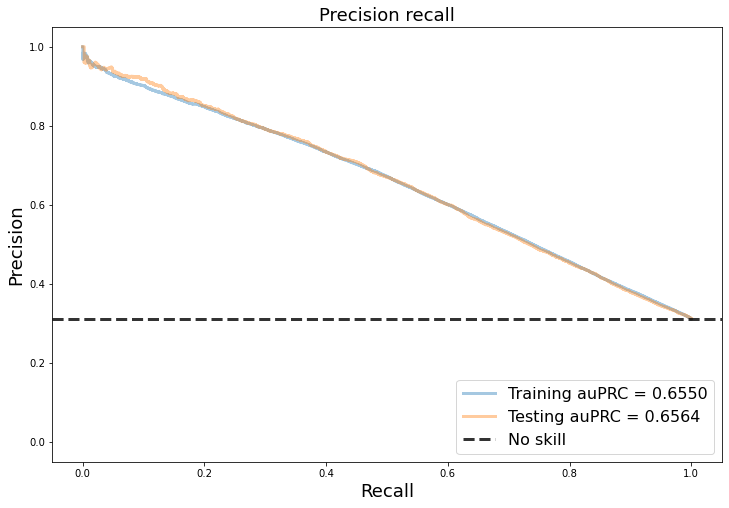

In [134]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.step(recs_tr, precs_tr, where='post', lw=3, alpha=0.4, label='Training auPRC = %0.4f' % (avg_prec_tr))
ax.step(recs, precs, where='post', lw=3, alpha=0.4, label='Testing auPRC = %0.4f' % (avg_prec))
ax.axhline(len(y_test[y_test==1])/len(y_test), linestyle='--', lw=3, color='k', label='No skill', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('Recall', fontsize=18)
ax.set_ylabel('Precision', fontsize=18)
ax.set_title('Precision recall', fontsize=18)
ax.legend(loc="lower right", fontsize=16);

### <u> **Reciever operating characteristic** </u>

In [135]:
from sklearn.metrics import roc_curve, auc

In [136]:
fprs_tr, tprs_tr, threshs_tr = roc_curve(y_true=y_train, y_score=y_tr_probs)
roc_auc_tr = auc(fprs_tr, tprs_tr)

In [137]:
fprs, tprs, threshs = roc_curve(y_true=y_test, y_score=y_probs)
roc_auc = auc(fprs, tprs)

In [138]:
roc_auc_tr, roc_auc

(0.7760402166226209, 0.7738164830815453)

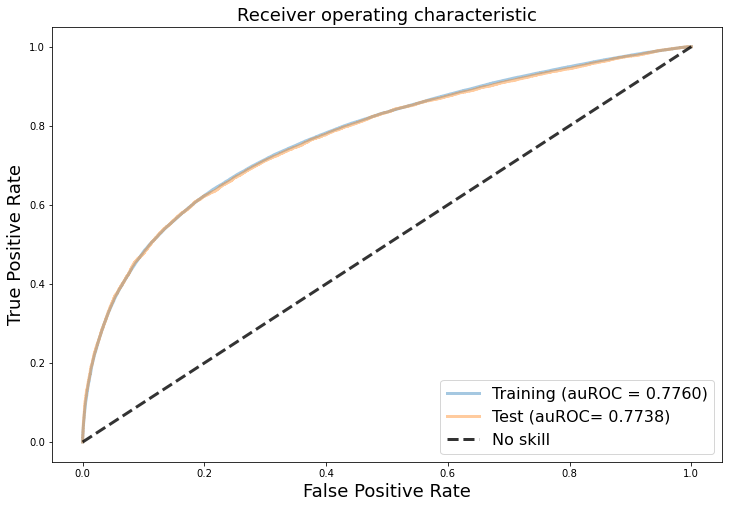

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(fprs_tr, tprs_tr, lw=3, alpha=0.4, label='Training (auROC = %0.4f)' % (roc_auc_tr))
ax.plot(fprs, tprs, lw=3, alpha=0.4, label='Test (auROC= %0.4f)' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='k', label='No skill', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('Receiver operating characteristic', fontsize=18)
ax.legend(loc="lower right", fontsize=16);

## Save the classifier
Classifier is already saved by the LS-GKM tool

# Scratch

# References